## Introducción

Imagina que quisieras modelar computacionalmente (como en esta clase) un sistema con muchísimos componentes, por ejemplo, tránsito, apostadores, difusión de gases, la economía de un páis o localidad, etc. ¿Cómo le harías?

Por ejemplo, para el caso de como se diluye una gota de tinta en un vaso con agua, la aproximación clásica (o sea, usando todo el aparato matemático clásico de las ecuaciones diferenciales) es:

- Tomar la posición $\vec{x}$ y el momento $\vec{p}$ de cada molécula en el vaso + la gota de la tinta, en un momento $t = t_0$.

- Usar las ecuaciones de Newton para el sistema (que son ecuaciones diferenciales ordinarias de segundo orden).

- Escribirlas como un sistema (más grande!) de ecuaciones diferenciales de primer orden.

- Resolverlas con un método de integración.

¿Estamos de acuerdo? Yo sé que es mucho trabajo, pero bueno, en realidad, lo va a hacer la computadora ¿Qué nos preocupa?

Bueno, pensemos en la implementación:

Existen $10^{23}$ moléculas (aproximadamente, y este dato proviene del [número de avogadro](http://en.wikipedia.org/wiki/Avogadro_constant) ). Cada partícula tiene 6 [grados de libertad](http://en.wikipedia.org/wiki/Degrees_of_freedom_%28mechanics%29) (6 _dof_) : 3 para la posición y 3 para la velocidad.

<div class="alert alert-info">
**Ejercicio** ¿Por qué 6 grados de libertad?
</div>

<div class="alert alert-info">
**Ejercicio** ¿Cuánta memoria se tiene que utilizar para guardar la configuración de las moléculas en el tiempo $t_0$? ¿Cabe en tu compu? ¿Cuántos discos duros requieres para guardarlo? ¿Cuánto costaría?
</div>

Además del problema que encontraron, el resolver el sistema _así_ no nos da mucho entendimiento, ya que habría que ejecutarlo para **cada** pregunta que hagamos: _¿Cuánto tiempo toma a que las moléculas de la gota de tinta se dispersen por todo el vaso?_ Calculamos y (suponiendo que se puede hacer) obtenemos una respuesta, pero y si queremos responder _¿Qué tal si el vaso es el doble de grande?_ ¡hay que calcularlo de nuevo!

## Métodos estocásticos

Una técnica que puede ser empleada (y muy relacionada con Montecarlo) son los _métodos estocásticos_.

La idea básica es la siguiente:


Un [_ensamble_ o _colectivo_](http://en.wikipedia.org/wiki/Statistical_ensemble_%28mathematical_physics%29) actúa de una manera **promedio** aún si los elementos que conforman el ensamble actúan al azar.


El resultado de esto es la pérdida de la información sobre los componentes del sistema, para ganar conocimiento sobre el  colectivo.

### Ejemplo: Caminata aleatoria

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import random

Populating the interactive namespace from numpy and matplotlib


La _caminata aleatoria_ o _caminata del borracho_ es el recorrido que se obtiene si en cada instante de tiempo "elegimos al azar" la siguiente dirección.

El siguiente código calcula la caminata aleatoria en una dimensión ($x$).

In [3]:
# Inicialización

steps = 200
posicion = np.zeros([steps])
tiempo = range(steps)

In [6]:
# caminamos ...
for i in range(1,steps):
    # Escojo aleatoriamente entre adelante o atrás
    # Si es igual a atrás, le quito una 1
    # Sino, le agrego 1
    if random.choice([u'adelante', u'atrás']) == u'atrás':
        posicion[i] = posicion[i-1] - 1
    else:
        posicion[i] = posicion[i-1] + 1

Text(0, 0.5, 'posición')

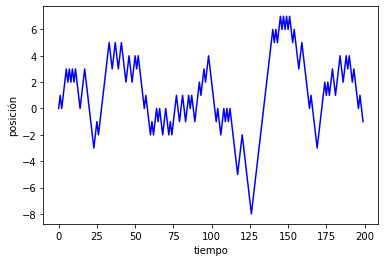

In [7]:
plt.plot(tiempo,posicion, 'b-')
plt.xlabel('tiempo')
plt.ylabel(u'posición')

Al parecer uno puede avanzar (¡o inclusive llegar a su casa si está borracho¡ -por lo menos en una dimensión.)

Pero como mencionamos arriba, lo que queremos es el _comportamiento promedio_ del borracho. 

Para lograrlo, utilizaremos miles de borrachos no interactuantes y calcularemos la [**media cuadrática**](http://en.wikipedia.org/wiki/Root_mean_square) o **RMS**.

<div class="alert alert-info">
**Ejercicio**: ¿Por qué utilizar una media cuadrática? ¿Qué pasa si hubiésemos usado el promedio simple?
</div>

In [8]:
# Inicialización

pasos = 200
borrachos = 2000

posicion = np.zeros([borrachos, pasos])  # todos empiezan en ceros
tiempo = range(steps)

for borracho in range(borrachos):
    for paso in range(1, pasos):
        if random.choice(['adelante', u'atrás']) == u'atrás':
            posicion[borracho, paso] = posicion[borracho,paso - 1] - 1
        else:
            posicion[borracho, paso] = posicion[borracho,paso - 1] + 1
            

promedio = np.mean(posicion, axis=0) # promedio
rms = np.sqrt(np.mean(np.square(posicion), axis=0)) # media cuadrática 
        


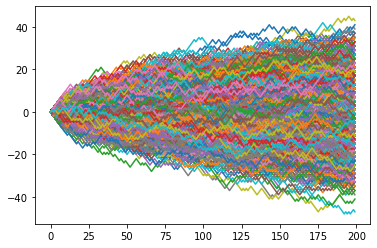

In [9]:
# Todos los borrachos a la vez
for borracho in range(borrachos):
    plt.plot(tiempo, posicion[borracho, :], '-')

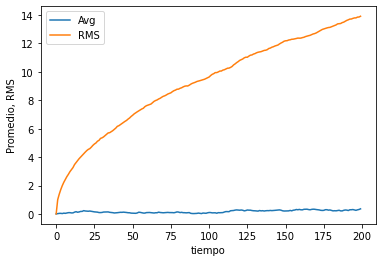

In [10]:
plt.plot(tiempo, promedio, label='Avg')
plt.plot(tiempo, rms, label='RMS')
plt.xlabel('tiempo')
plt.ylabel('Promedio, RMS')
plt.legend(loc='best')

In [11]:
from scipy.optimize import curve_fit

power_law = lambda x, a, b: a*x**b

popt, pcov = curve_fit(power_law, tiempo, rms)

Estamos proponiendo que los datos ajustan a una ley de potencias del tipo 

$$y(t) = A t^B$$

Que en este caso en particualar es:

In [15]:
print("A = %f +/- %f." % (popt[0], sqrt(pcov[0,0])))
print("B = %f +/- %f." % (popt[1], sqrt(pcov[1,1])))

A = 0.970535 +/- 0.005245.
B = 0.502538 +/- 0.001121.


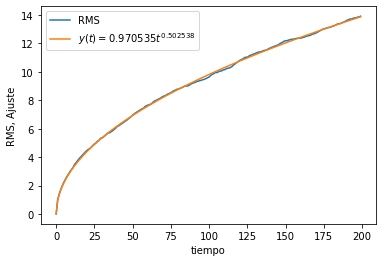

In [16]:
plt.plot(tiempo, rms, label="RMS")
plt.plot(tiempo,power_law(tiempo, popt[0], popt[1]), label=r"$y(t) = %f t ^{%f}$" % (popt[0], popt[1]))
plt.xlabel('tiempo')
plt.ylabel(r'RMS, Ajuste')
plt.legend(loc='best')

### Ejemplo: Difusión

La difusión es el ejemplo con el que iniciamos la discusión, básicamente es una caminata aleatoria en 2D.

(0.0, 200.0)

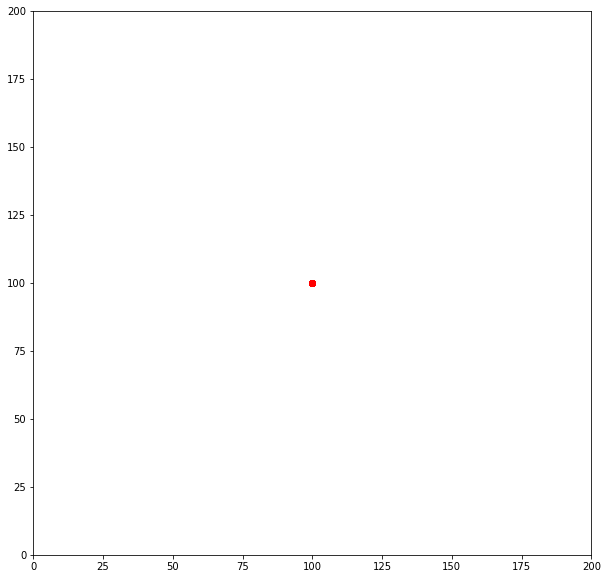

In [17]:
plt.figure(figsize = (10,10))

num_particulas = 400

particulas = np.ones([num_particulas,2])*100  # Todas las partículas en el punto (100,100)


# Dibujamos la posición inicial
line, = plt.plot(particulas[:,0], particulas[:,1], 'ro')
plt.xlim(0,200)
plt.ylim(0,200)


# agregarle cosas al borracho

In [18]:
steps = 5000

for i in range(steps):
    for particula in range(num_particulas):
        particulas[particula, 0] += random.randint(-1, 1)
        particulas[particula, 1] += random.randint(-1, 1)
        
        # Verificar colisión
        x, y = (particulas[particula, 0], particulas[particula, 1])
        if x == 200:
            particulas[particula, 0] = 198
        elif x == 0:
            particulas[particula, 0] = 2
        
        if y == 200:
            particulas[particula, 1] = 198
        elif y == 0:
            particulas[particula, 1] = 2
            

(0.0, 200.0)

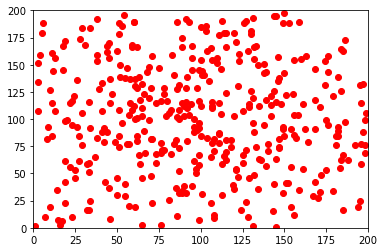

In [19]:
# Dibujamos la posición luego de N steps
line, = plt.plot(particulas[:,0], particulas[:,1], 'ro')
plt.xlim(0,200)
plt.ylim(0,200)

<div class="alert alert-info">
**Ejercicio:** ¿Cómo modificarías el código para que pudieras usarlo en una animación?
</div>

<div class="alert alert-info">
**Ejercicio:** ¿Y para mostrarlo en un subplot cada 10 pasos?
</div>